In [27]:
from numpy.polynomial.polynomial import Polynomial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from help_functions_non_njit import *
import seaborn as sns
from scipy.stats import multivariate_normal, lognorm, norm
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

# Indbetalingsprocent

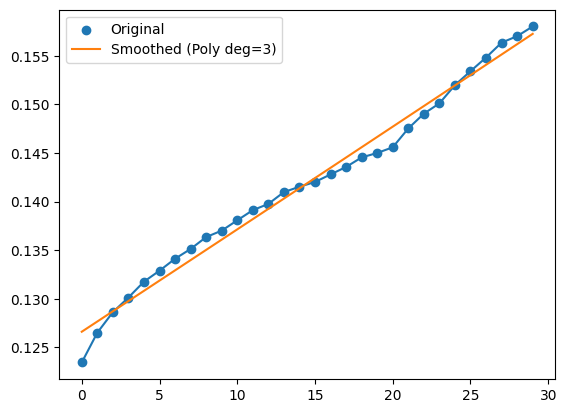

In [28]:
indbet = np.array(pd.read_csv("Data/mean_matrix.csv")['indbetalingsprocent_sum'])
indbet = indbet[~np.isnan(indbet)][:30]
plt.plot(indbet)

# Example data (replace x and y with your actual data)
x = np.arange(len(indbet))  # or actual x values
y = indbet

# Fit polynomial of degree 3
coefs = Polynomial.fit(x, y, deg=2)
y_smooth = coefs(x)

# Plot
plt.scatter(x, y, label='Original')
plt.plot(x, y_smooth, label='Smoothed (Poly deg=3)')
plt.legend()
plt.show()
years = np.arange(70)
co = coefs(years)
pd.DataFrame(co).rename(columns={0: 'indbetalingsprocent_sum'}).to_csv("Smooth_data/smooth_indbet.csv", index=False)


# Overlevelses ssh

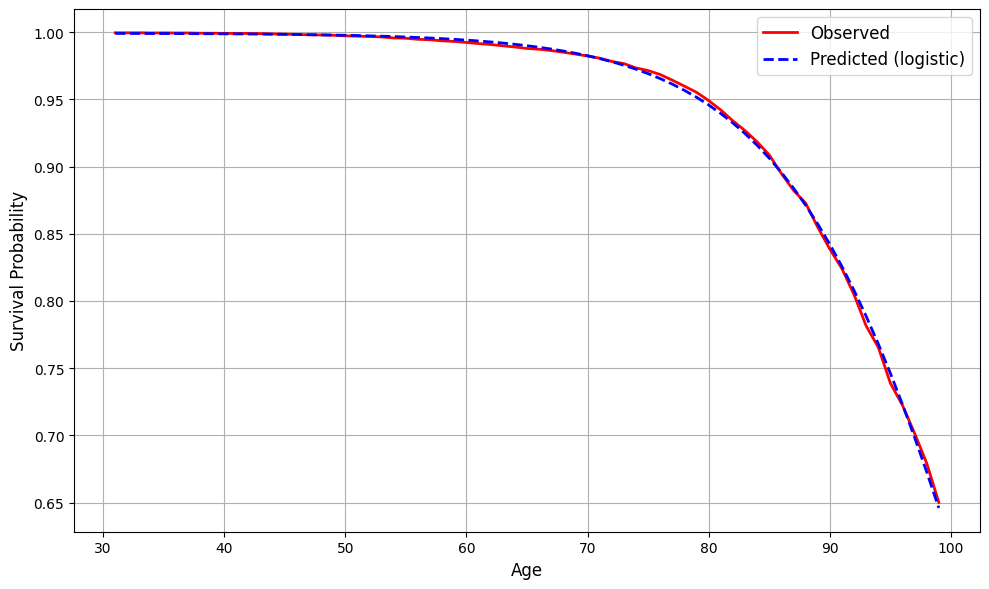

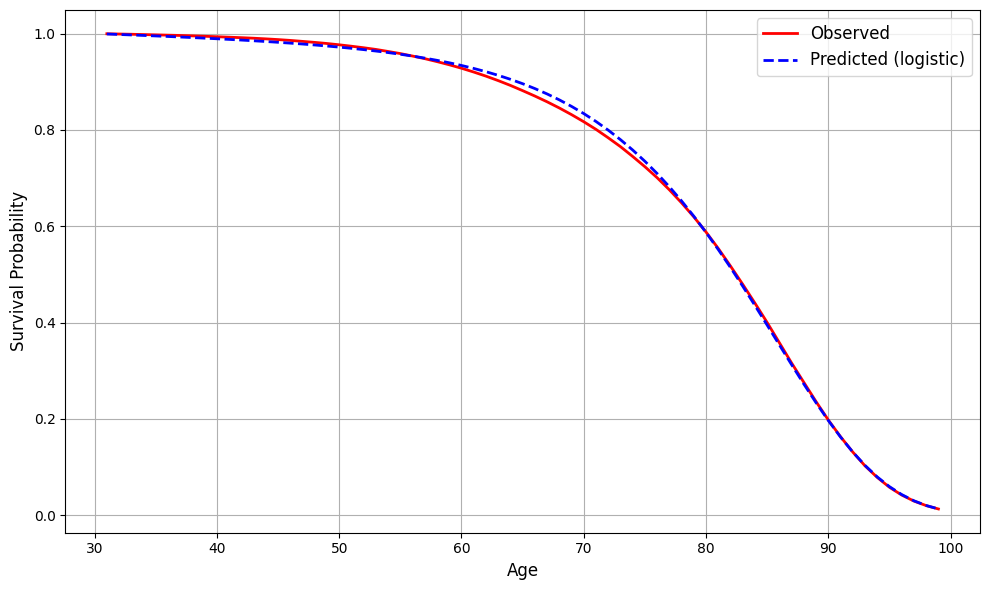

In [29]:
df = pd.read_csv('Data/overlevelse_ssh.csv')
L = 0.9992 # fra regression og data i sas
f = -0.1195 # fra regression og data i sas
x0 = 74.0520 # fra regression og data i sas

df['predicted'] = logistic(df['alder'],L, f, x0)  
pd.DataFrame(co).to_csv("Smooth_data/survival_ssh.csv", index=False)


# Create a single, nice-looking plot
plt.figure(figsize=(10, 6))
plt.plot(df['alder']+30, df['survival_Mean'], label='Observed', color='red', linewidth=2)
plt.plot(df['alder']+30, df['predicted'], label='Predicted (logistic)', color='blue', linestyle='--', linewidth=2)

# Style it
plt.xlabel('Age', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Optional: save to file
plt.savefig("andet/pictures/conditional_survival_fit.png")

plt.show()

df['observed_unconditional'] = np.cumprod(df['survival_Mean'])
df['predicted_unconditional'] = np.cumprod(df['predicted'])

# Create a single, nice-looking plot
plt.figure(figsize=(10, 6))
plt.plot(df['alder']+30, df['observed_unconditional'], label='Observed', color='red', linewidth=2)
plt.plot(df['alder']+30, df['predicted_unconditional'], label='Predicted (logistic)', color='blue', linestyle='--', linewidth=2)

# Style it
plt.xlabel('Age', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Optional: save to file
plt.savefig("andet/pictures/unconditional_survival_fit.png")

plt.show()

# Transitions ssh for employment

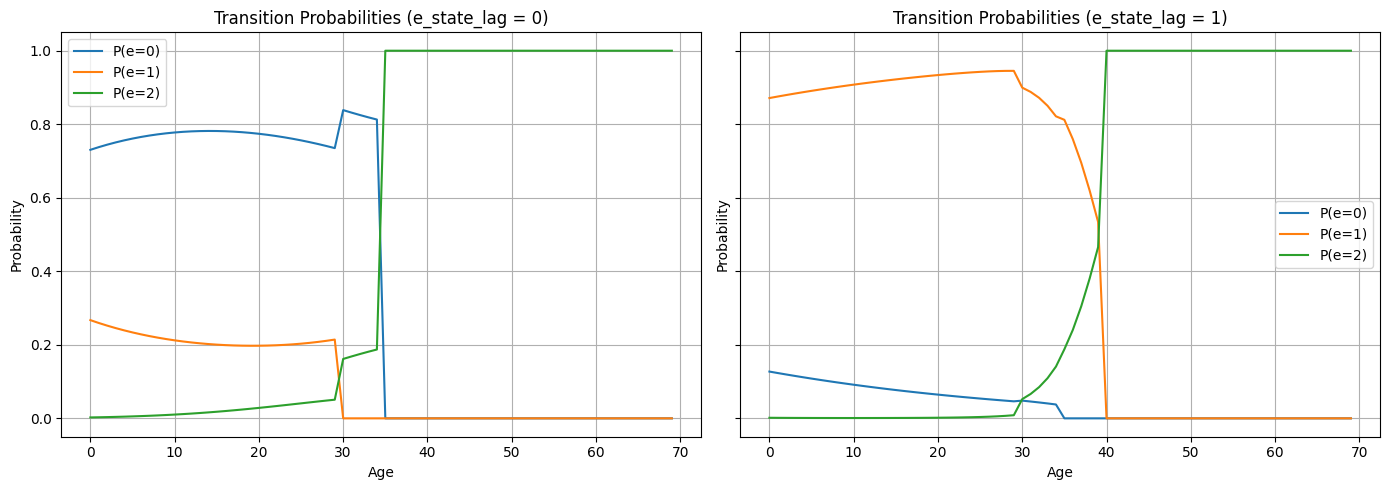

In [30]:

# parameter_table = pd.read_csv("Data/transition_ssh_para.csv")[['Variable', 'Response', 'Estimate']]
parameter_table_with_control = pd.read_csv("Data/transitin_ssh_para_med_kontrol.csv")[['Variable', 'Response', 'Estimate']]

def compute_transition_probs(x, param_table):
    eta = {1: 0.0, 2: 0.0}
    for _, row in param_table.iterrows():
        var = row["Variable"]
        response = row["Response"]
        estimate = row["Estimate"]

        if var == "Intercept":
            eta[response] += estimate
        else:
            if var in x:
                eta[response] += estimate * x[var]
            elif "*" in var:
                terms = var.split("*")
                val = np.prod([x.get(t, 0) for t in terms])
                eta[response] += estimate * val

    exp_eta1 = np.exp(eta[1])
    exp_eta2 = np.exp(eta[2])
    denom = 1 + exp_eta1 + exp_eta2

    return {
        0: 1 / denom,
        1: exp_eta1 / denom,
        2: exp_eta2 / denom
    }

# Age range
age_end = 41
ages = np.arange(0, 70)

# DataFrame to collect results
results = []

# Compute for e_state_lag = 0 and 1
for e_state_lag in [0, 1]:
    for age in ages:
        x_input = {
            "e_state_lag": e_state_lag,
            "alder": age,
            "alder2": age**2,
            "dummy_60_65": int(age_end-11 <= age ),
            "alder*e_state_lag": age * e_state_lag,
            "alder2*e_state_lag": (age**2) * e_state_lag,
            "dummy_60_*e_state_la": int(age_end-11 <= age) * e_state_lag
        }
        # 👉 Force P(e=2) = 0 at age 35
        probs = compute_transition_probs(x_input, parameter_table_with_control)

        if e_state_lag == 0:
            if age >= 35:
                # Must go on early retirement
                probs[0] = 0.0
                probs[1] = 0.0
                probs[2] = 1.0
            elif age >= 30:
                # Cannot be hired
                probs[1] = 0.0
                total = probs[0] + probs[2]
                probs[0] /= total
                probs[2] /= total

        elif e_state_lag == 1:
            if age>= 40:
                probs[0] = 0.0
                probs[1] = 0.0
                probs[2] = 1.0
            elif age >= 35:
                # Move all P(e=1) mass to P(e=2)
                probs[0] = 0.0
                total = probs[1] + probs[2]
                probs[1] /= total
                probs[2] /= total

        results.append({
            "age": age,
            "e_state_lag": e_state_lag,
            "P_0": probs[0],
            "P_1": probs[1],
            "P_2": probs[2]
        })


# Convert to DataFrame
df = pd.DataFrame(results)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
for lag, ax in zip([0, 1], axes):
    sub_df = df[df["e_state_lag"] == lag]
    ax.plot(sub_df["age"], sub_df["P_0"], label="P(e=0)")
    ax.plot(sub_df["age"], sub_df["P_1"], label="P(e=1)")
    ax.plot(sub_df["age"], sub_df["P_2"], label="P(e=2)")
    ax.set_title(f"Transition Probabilities (e_state_lag = {lag})")
    ax.set_xlabel("Age")
    ax.set_ylabel("Probability")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig("andet/pictures/transition_probs.png")  # Or .jpg, .svg, etc.
plt.show()

# Skatteprocenterne

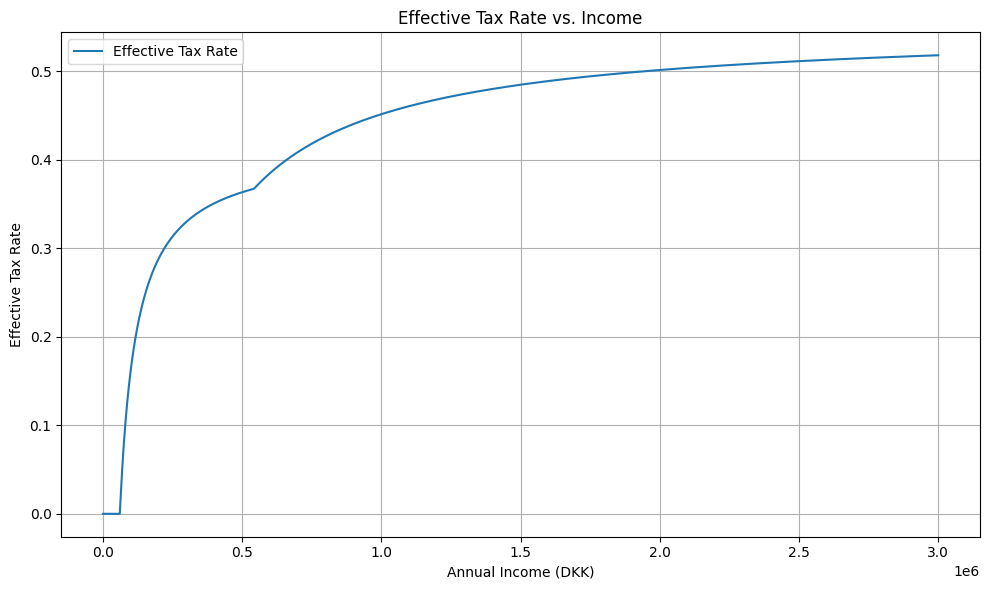

In [31]:
# Constants (same as the SAS code, simplified for loen = "ja")
am_sats                   = 0.08
beskfradrag_sats          = 0.875
bundskat_sats             = 0.113
topskat_sats              = 0.15
kommuneskat_sats          = 0.2491
personfradrag             = 46000
beskfradrag_graense       = 33300
topskat_graense           = 498900

def calculate_tax_rate(ind_aar):

    am_aar = ind_aar * am_sats
    personlignd_aar = (ind_aar - am_aar)
    grundlag_aar = max(personlignd_aar - personfradrag, 0)
    beskfradrag_aar = min(beskfradrag_graense, ind_aar * beskfradrag_sats)
    skattepligt_aar = (grundlag_aar - beskfradrag_aar)
    bundskat_aar = (grundlag_aar * bundskat_sats)
    topskat_aar = (topskat_sats * max(personlignd_aar - topskat_graense, 0))
    kommuneskat_aar = (kommuneskat_sats * skattepligt_aar)

    # Notice kirkeskat was never added to 'indkomstskat' in the original code
    indkomstskat_aar = (am_aar + bundskat_aar + topskat_aar + kommuneskat_aar)
    ind_efter_aar = (ind_aar - indkomstskat_aar)

    # Effective tax rate
    skatteprocent_aar = max(1 - (ind_efter_aar / ind_aar), 0)
    return skatteprocent_aar


incomes = np.linspace(1, 3000000, 1000)
tax_rates = []

tax_rates = [calculate_tax_rate(x) for x in incomes]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(incomes, tax_rates, label="Effective Tax Rate")
plt.xlabel("Annual Income (DKK)")
plt.ylabel("Effective Tax Rate")
plt.title("Effective Tax Rate vs. Income")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Initial values 

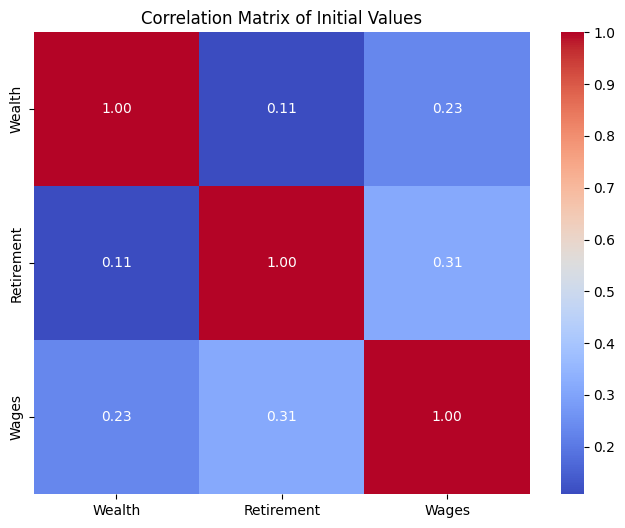

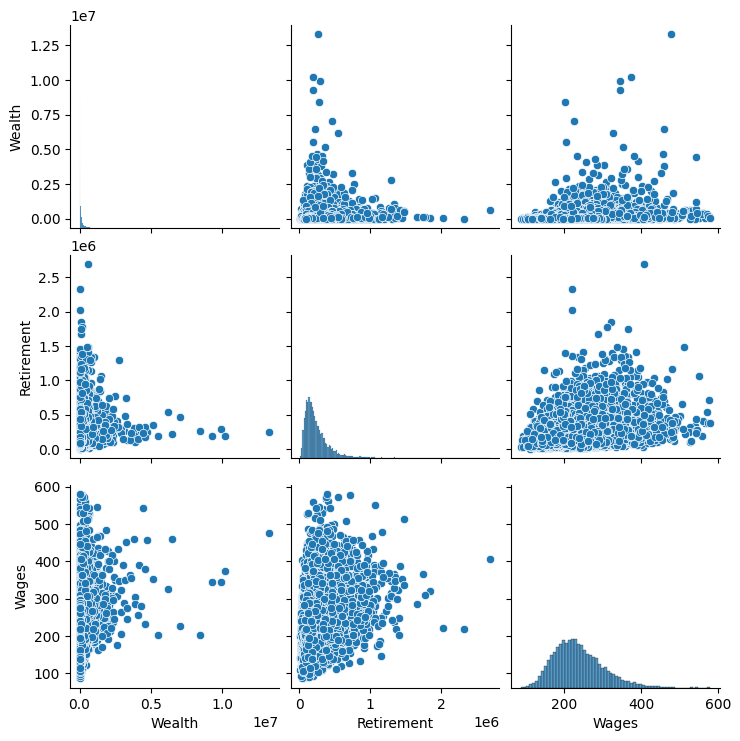

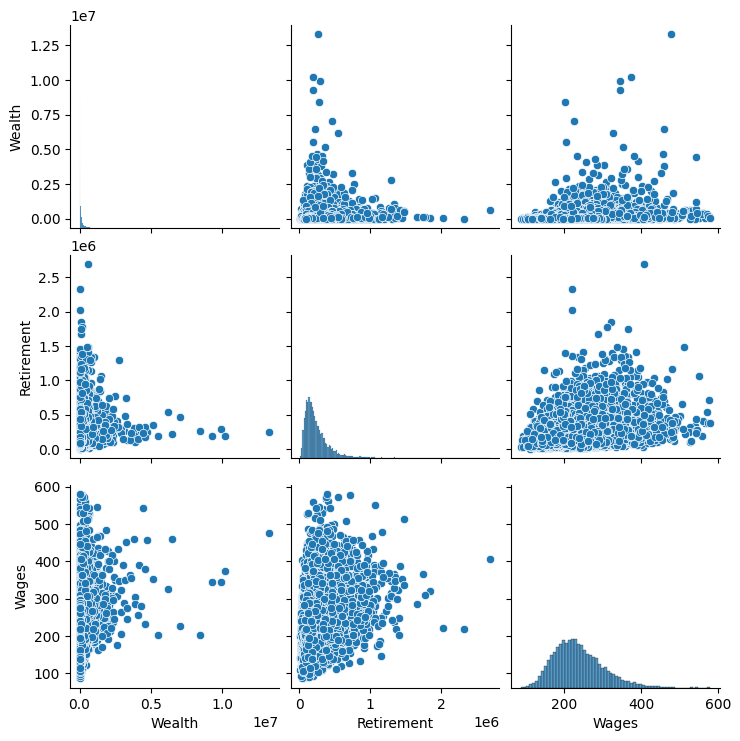

In [32]:
wealth, retirement, wages = draw_initial_values(10000)
df = pd.DataFrame({
    "Wealth": wealth,
    "Retirement": retirement,
    "Wages": wages
})
# Calculate correlation matrix
corr_matrix = df.corr()

# Create the heatmap plot
plt.figure(figsize=(8, 6))  # Optional: adjust size
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Initial Values")

# Save the plot
plt.savefig("Andet/Pictures/correlation_matrix_initial_values.png", dpi=300, bbox_inches='tight')

# Optional: Show the plot
plt.show()

sns.pairplot(df)
plt.show()
pairplot = sns.pairplot(df)

pairplot.savefig("Andet/Pictures/pairplot_initial_values.png", dpi=300)  # You can also use .pdf or .jpg


# Renter på pensionsformue

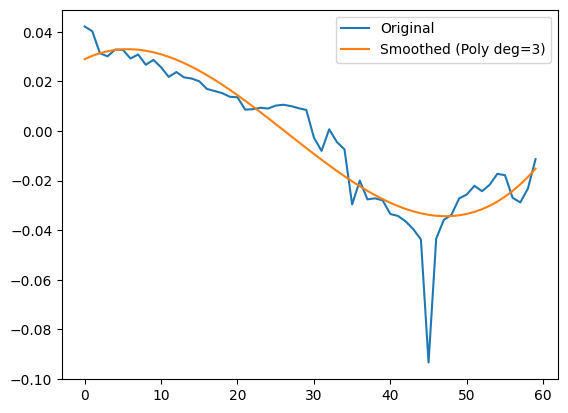

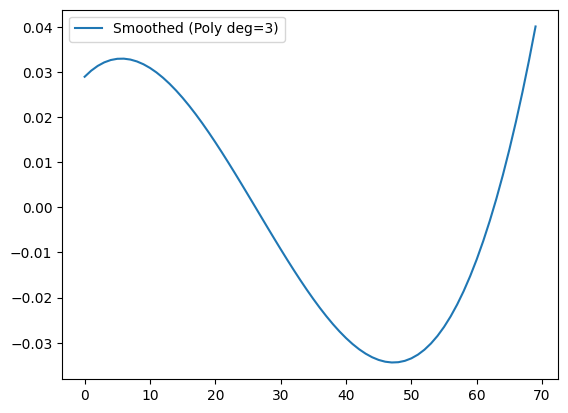

In [33]:
rente = np.array(pd.read_csv("Data/mean_matrix.csv")['rente_pension_sum'])
rente = rente[~np.isnan(rente)][:60]

x_r = np.arange(len(rente))  # or actual x values

# Fit polynomial of degree 3
coefs = Polynomial.fit(x_r, rente, deg=3)
rente_smooth = coefs(x_r)

# Plot
plt.plot(x_r, rente, label='Original')
plt.plot(x_r, rente_smooth, label='Smoothed (Poly deg=3)')
plt.legend()
plt.show()
years = np.arange(70)
co = coefs(years)


T = 70
x_T = np.arange(T)
rente_smooth_long = coefs(x_T)


# Plot
plt.plot(x_T, rente_smooth_long, label='Smoothed (Poly deg=3)')
plt.legend()
plt.show()


pd.DataFrame(rente_smooth_long).rename(columns={0: 'rente_s'}).to_csv("Smooth_data/smooth_rente_s.csv", index=False)



In [34]:
rente = np.array(pd.read_csv("Data/mean_matrix.csv")['rente_pension_sum'])
np.mean(np.array(pd.read_csv("Data/mean_matrix.csv")['rente_pension_sum'])[:60])

np.float64(-0.0029413226416666665)

# Early retirement benefits

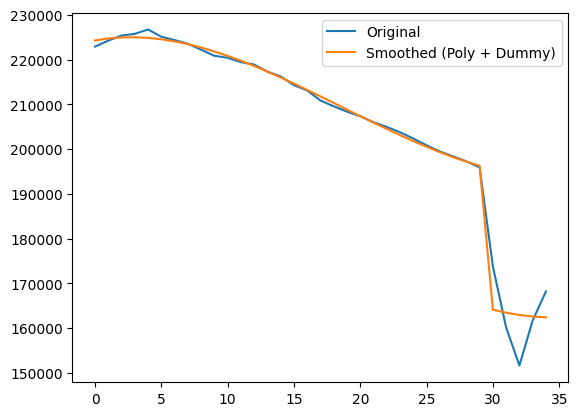

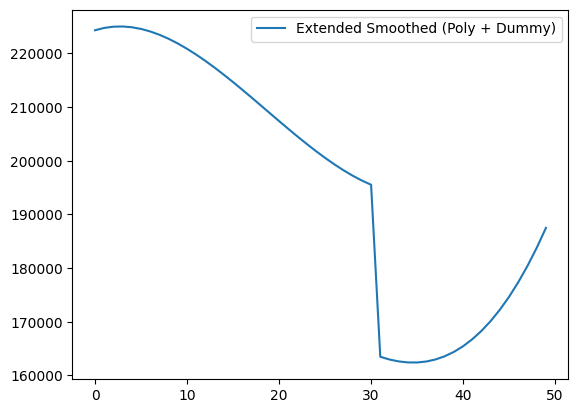

In [38]:
# Load data
overfor_2 = pd.read_csv('data/mean_matrix.csv')['overfor_2']
overfor_2 = overfor_2[~np.isnan(overfor_2)][:40]

# Set x values
x_r = np.arange(len(overfor_2))

# Create polynomial features
X_poly = np.vstack([x_r**i for i in range(4)]).T  # deg 3 -> x^0, x^1, x^2, x^3

# Create dummy variable for x > 30
dummy = (x_r >= 30).astype(int).reshape(-1, 1)

# Combine polynomial features and dummy
X = np.hstack([X_poly, dummy])

# Fit linear model
model = LinearRegression().fit(X, overfor_2)

# Predict smoothed values on same range
overfor_2_smooth = model.predict(X)

# Plot original and smoothed
plt.plot(x_r, overfor_2, label='Original')
plt.plot(x_r, overfor_2_smooth, label='Smoothed (Poly + Dummy)')
plt.legend()
plt.show()

# Extend prediction to 70 years
years = np.arange(50)
X_poly_long = np.vstack([years**i for i in range(4)]).T
dummy_long = (years > 30).astype(int).reshape(-1, 1)
X_long = np.hstack([X_poly_long, dummy_long])
co_long = model.predict(X_long)

# Plot extended prediction
plt.plot(years, co_long, label='Extended Smoothed (Poly + Dummy)')
plt.legend()
plt.show()

# Gem koefficietnerne til modellen
model.coef_[0] = model.intercept_
np.savetxt('coefs_early_benefit.csv', model.coef_, delimiter=',')

# Unemployment benefits

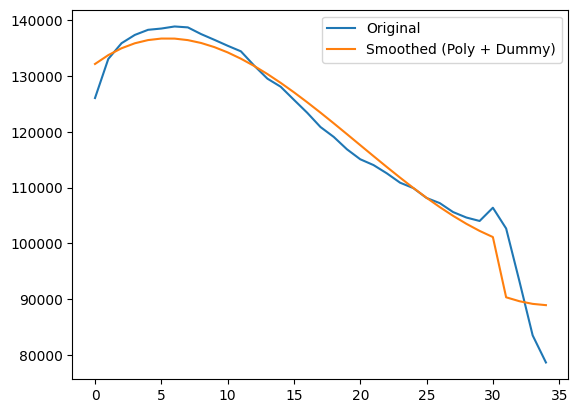

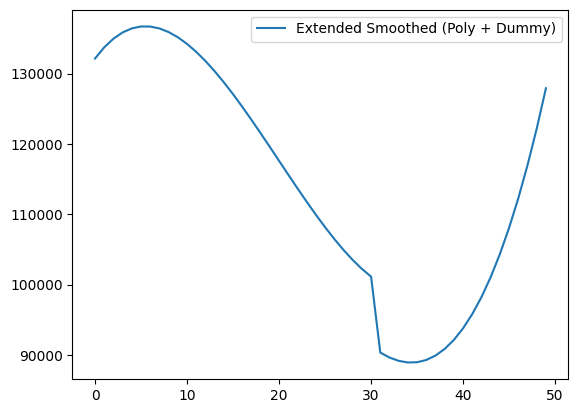

In [36]:
# Load data
overfor_0 = pd.read_csv('data/mean_matrix.csv')['overfor_0']
overfor_0 = overfor_0[~np.isnan(overfor_0)][:40]

# Set x values
x_r = np.arange(len(overfor_0))

# Create polynomial features
X_poly = np.vstack([x_r**i for i in range(4)]).T  # deg 3 -> x^0, x^1, x^2, x^3

# Create dummy variable for x > 30
dummy = (x_r > 30).astype(int).reshape(-1, 1)

# Combine polynomial features and dummy
X = np.hstack([X_poly, dummy])

# Fit linear model manually (no sklearn needed)
coefs, _, _, _ = np.linalg.lstsq(X, overfor_0, rcond=None)

# Plot original and smoothed
overfor_0_smooth = X @ coefs

plt.plot(x_r, overfor_0, label='Original')
plt.plot(x_r, overfor_0_smooth, label='Smoothed (Poly + Dummy)')
plt.legend()
plt.show()

# Extend prediction to 50 years
years = np.arange(50)
X_poly_long = np.vstack([years**i for i in range(4)]).T
dummy_long = (years > 30).astype(int).reshape(-1, 1)
X_long = np.hstack([X_poly_long, dummy_long])

# Predict extended
co_long = X_long @ coefs

plt.plot(years, co_long, label='Extended Smoothed (Poly + Dummy)')
plt.legend()
plt.show()


# Gem koefficietnerne til modellen
np.savetxt('coefs_unemployment_benefit.csv', model.coef_, delimiter=',')

# Employment benefits

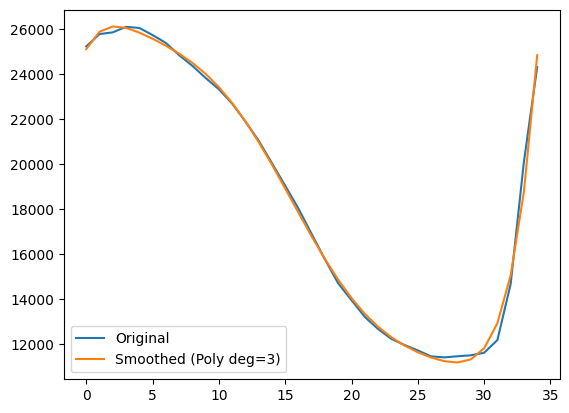

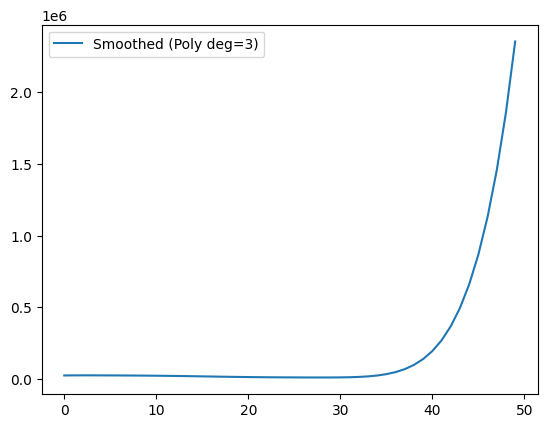

In [37]:
overfor_1 = pd.read_csv('data/mean_matrix.csv')['overfor_1']

overfor_1 = overfor_1[~np.isnan(overfor_1)][:40]

x_r = np.arange(len(overfor_1))  # or actual x values

# Fit polynomial of degree 3
coefs = Polynomial.fit(x_r, overfor_1, deg=7)
overfor_1_smooth = coefs(x_r)

# Plot
plt.plot(x_r, overfor_1, label='Original')
plt.plot(x_r, overfor_1_smooth, label='Smoothed (Poly deg=3)')
plt.legend()
plt.show()
years = np.arange(70)
co = coefs(years)

T = 50
x_T = np.arange(T)
overfor_1_smooth_long = coefs(x_T)

# Plot
plt.plot(x_T, overfor_1_smooth_long, label='Smoothed (Poly deg=3)')
plt.legend()
plt.show()
years = np.arange(70)
co_long = coefs(years)

